## Setup

In [168]:
# import the necessary packages
import tensorflow as tf
import gc
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16, DenseNet169
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout, GlobalAveragePooling2D, Activation, BatchNormalization, Dropout, LSTM, ConvLSTM2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input,Conv2D, SeparableConv2D, MaxPool2D, LeakyReLU, Activation, LSTM, ConvLSTM2D, Lambda, Reshape, BatchNormalization, Bidirectional
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint,TensorBoard,TerminateOnNaN, LearningRateScheduler
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, TerminateOnNaN
from tensorflow.keras.layers import Lambda, Reshape, DepthwiseConv2D, ZeroPadding2D, Add, MaxPooling2D,Activation, Flatten, Conv2D, Dense, Input, Dropout, Concatenate, GlobalMaxPooling2D, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
from tensorflow.keras import backend as K

from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split, StratifiedKFold, RepeatedStratifiedKFold
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, auc
from imutils import paths
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import random
import shutil
import cv2
import os
from classification_models.tfkeras import Classifiers
from datetime import datetime
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [169]:
dataset_path = 'dataset'
log_path = 'logs'

## Build Dataset

In [170]:
%%bash
rm -rf dataset
mkdir -p dataset/covid
mkdir -p dataset/normal
mkdir -p dataset/pneumonia
mkdir -p logs

Couldn't find program: 'bash'


In [171]:
len(os.listdir('covid-chest-xray/images/'))

357

### Covid xray dataset

In [172]:
samples = 140

In [173]:
covid_dataset_path = 'covid-chest-xray'

In [174]:
csvPath = os.path.sep.join([covid_dataset_path, "metadata.csv"])
df = pd.read_csv(csvPath)

for (i, row) in df.iterrows():
    # if (1) the current case is not COVID-19 or (2) this is not
    # a 'PA' view, then ignore the row
    if row["finding"] != "COVID-19" or row["view"] != "PA":
        continue

    imagePath = os.path.sep.join([covid_dataset_path, "images", row["filename"]])

    if not os.path.exists(imagePath):
        continue

    filename = row["filename"].split(os.path.sep)[-1]
    outputPath = os.path.sep.join([f"{dataset_path}/covid", filename])

    shutil.copy2(imagePath, outputPath)

### Build normal xray dataset

In [175]:
pneumonia_dataset_path ='chest_xray_pneumonia/chest_xray'

In [176]:
basePath = os.path.sep.join([pneumonia_dataset_path, "train", "NORMAL"])
imagePaths = list(paths.list_images(basePath))

# randomly sample the image paths
random.seed(42)
random.shuffle(imagePaths)
imagePaths = imagePaths[:samples]

for (i, imagePath) in enumerate(imagePaths):
    filename = imagePath.split(os.path.sep)[-1]
    outputPath = os.path.sep.join([f"{dataset_path}/normal", filename])

    shutil.copy2(imagePath, outputPath)

### Build pneumonia xray dataset

In [177]:
basePath = os.path.sep.join([pneumonia_dataset_path, "train", "PNEUMONIA"])
imagePaths = list(paths.list_images(basePath))

# randomly sample the image paths
random.seed(42)
random.shuffle(imagePaths)
imagePaths = imagePaths[:samples]

for (i, imagePath) in enumerate(imagePaths):
    filename = imagePath.split(os.path.sep)[-1]
    outputPath = os.path.sep.join([f"{dataset_path}/pneumonia", filename])

    shutil.copy2(imagePath, outputPath)

In [178]:
len(os.listdir('dataset/normal'))

140

## Plot x-rays

In [179]:
def ceildiv(a, b):
    return -(-a // b)

def plots_from_files(imspaths, figsize=(10,5), rows=1, titles=None, maintitle=None):
    f = plt.figure(figsize=(40,10))
    if maintitle is not None: plt.suptitle(maintitle, fontsize=20)
    for i in range(len(imspaths)):
        sp = f.add_subplot(rows, ceildiv(len(imspaths), rows), i+1)
        sp.axis('Off')
        if titles is not None: sp.set_title(titles[i], fontsize=26)
        img = plt.imread(imspaths[i])
        plt.imshow(img, cmap = 'gray')

In [180]:
normal_images = list(paths.list_images(f"{dataset_path}/normal"))
covid_images = list(paths.list_images(f"{dataset_path}/covid"))
covid_images = list(paths.list_images(f"{dataset_path}/pneumonia"))

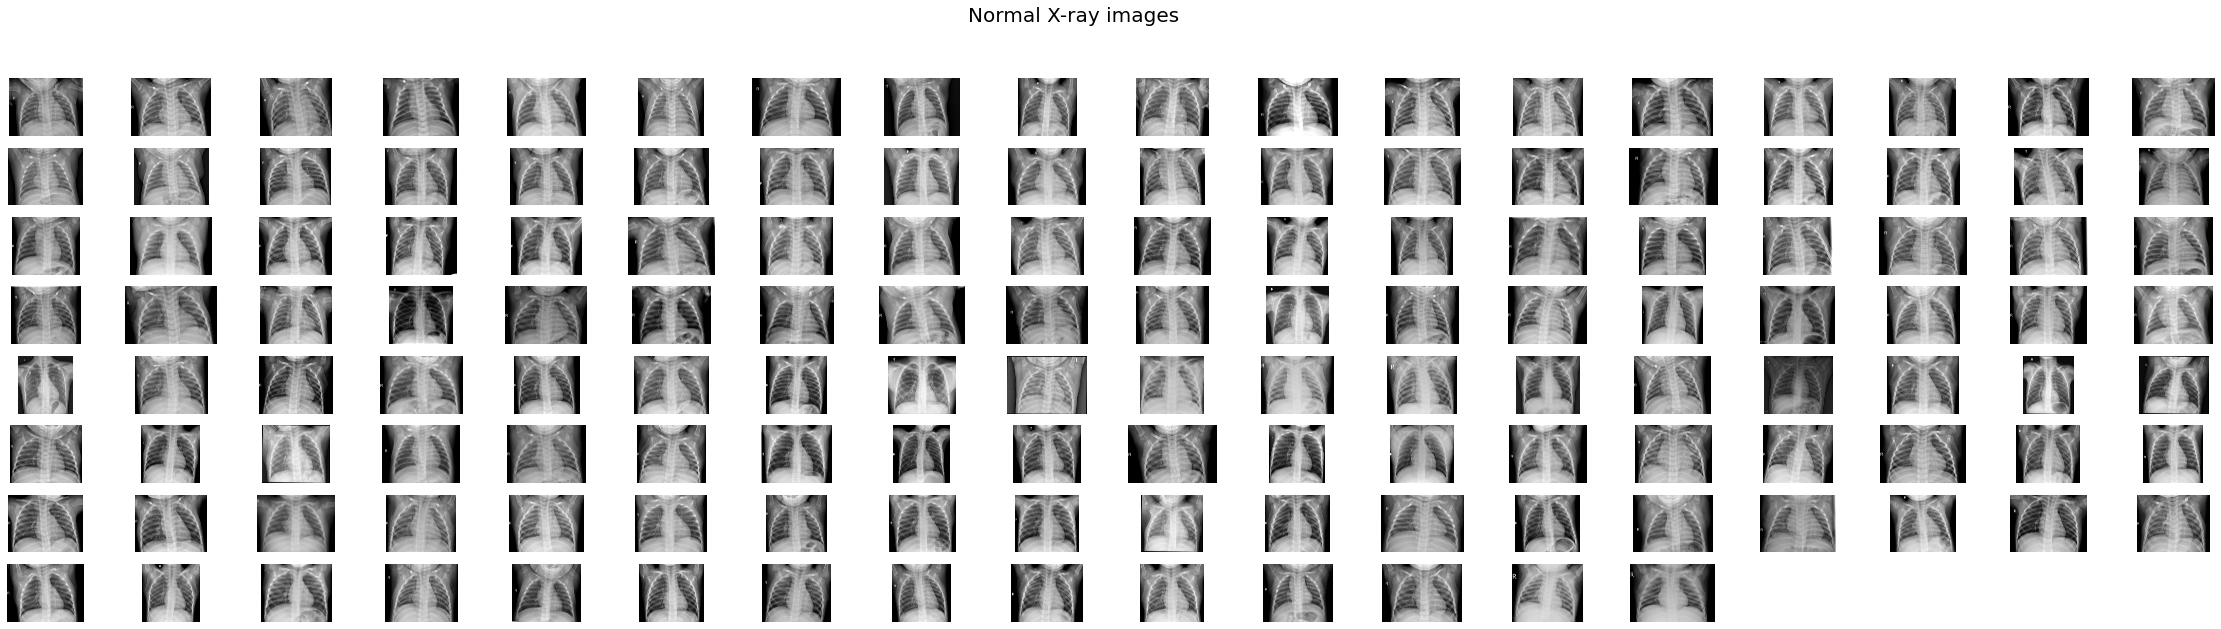

In [14]:
plots_from_files(normal_images, rows=8, maintitle="Normal X-ray images")

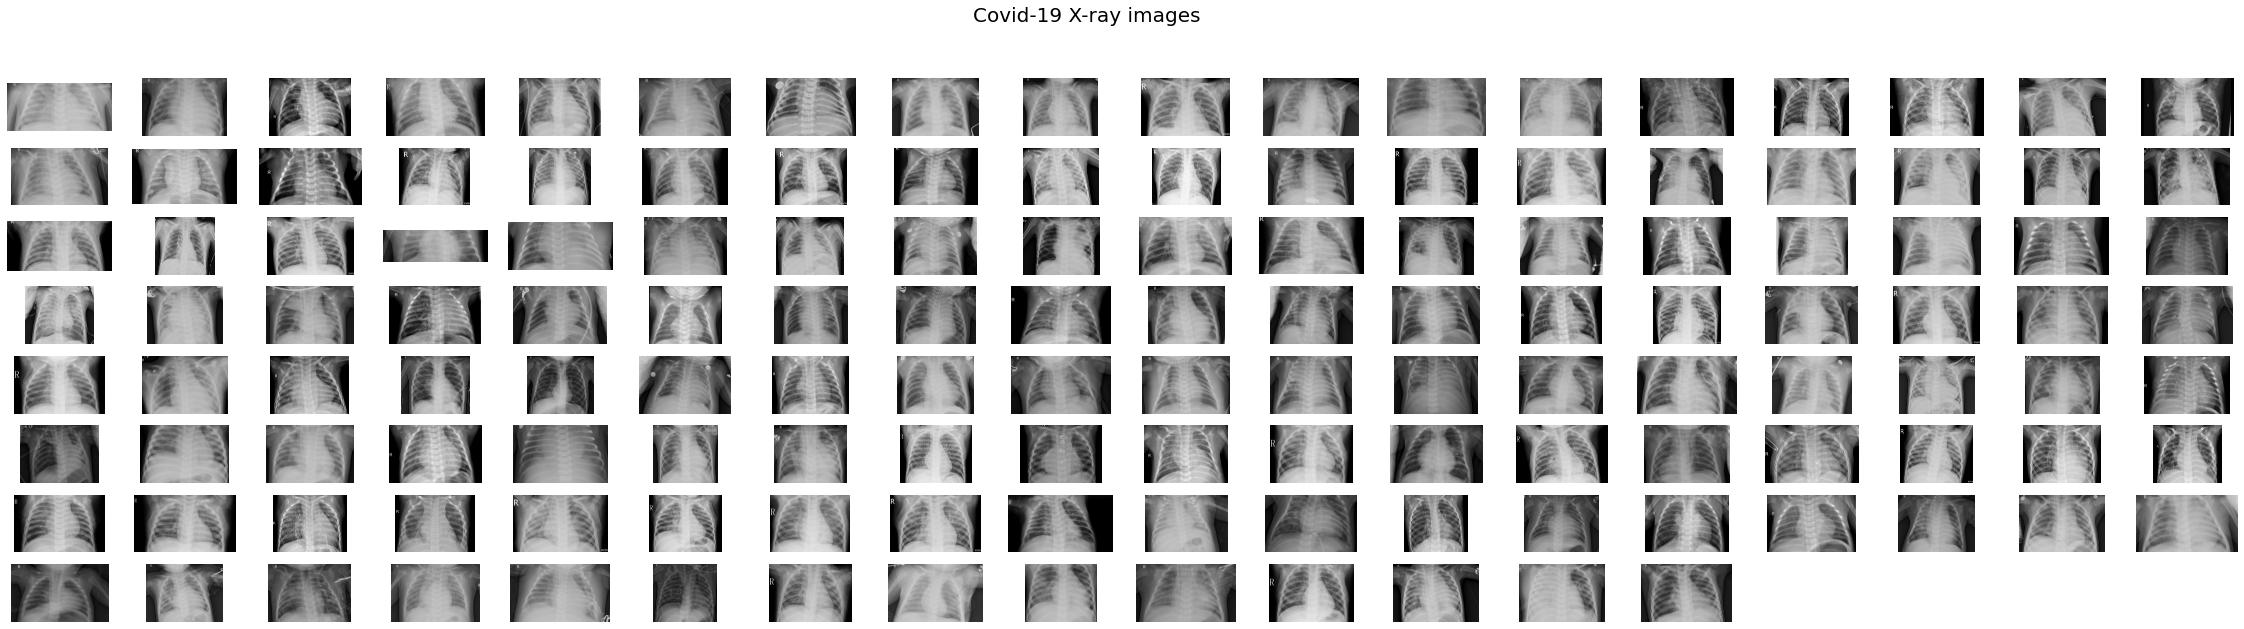

In [15]:
plots_from_files(covid_images, rows=8, maintitle="Covid-19 X-ray images")

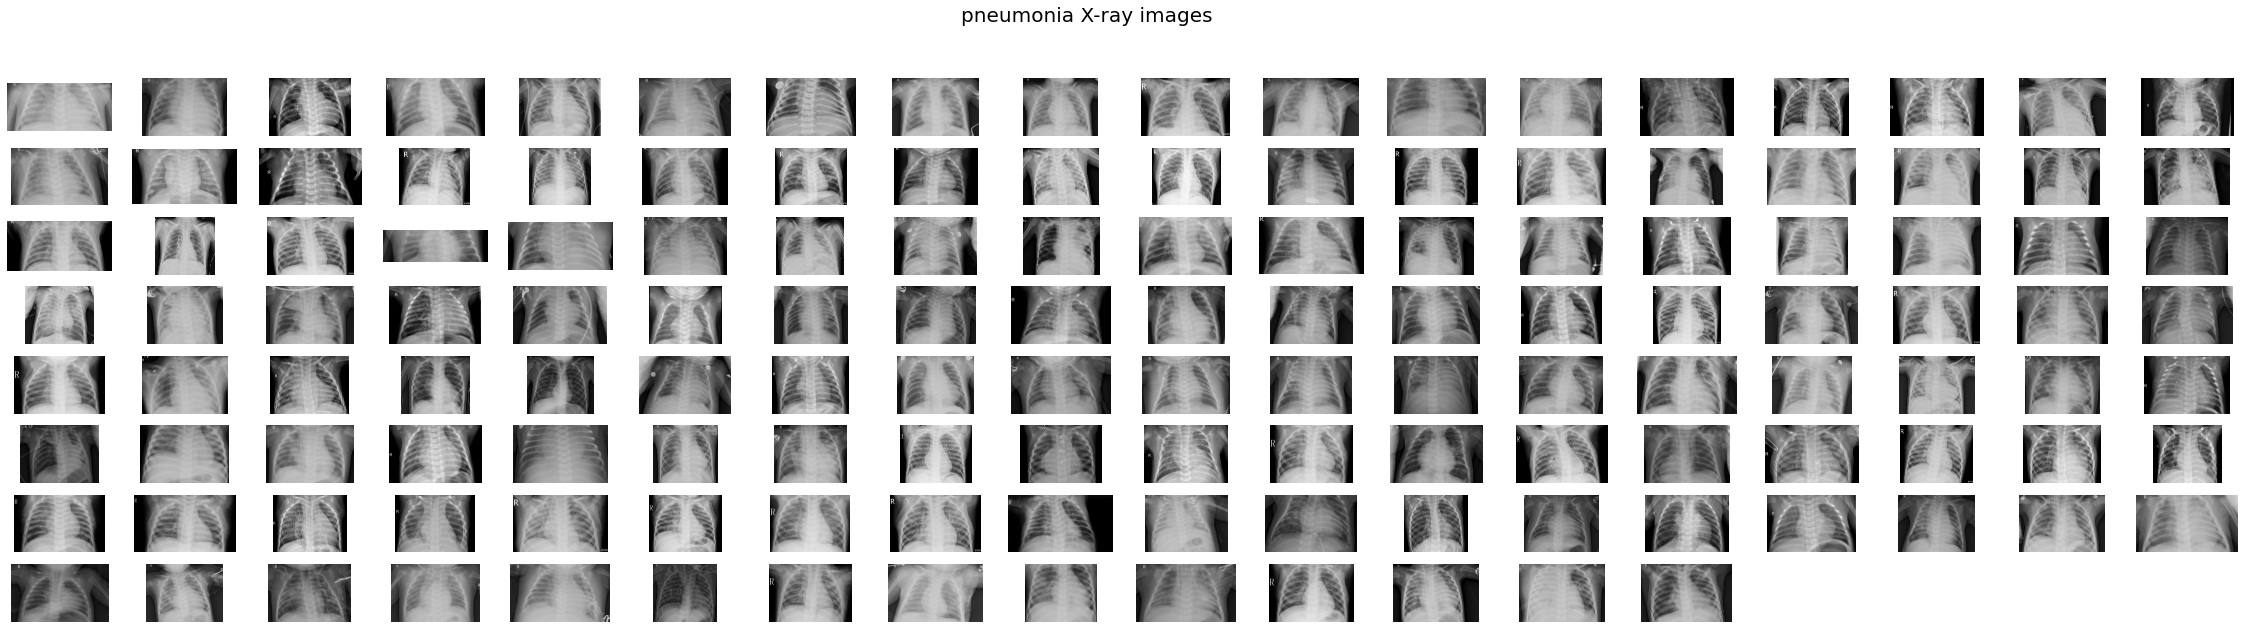

In [16]:
plots_from_files(covid_images, rows=8, maintitle="pneumonia X-ray images")

## Data preprocessing

In [181]:
class_to_label_map = {'pneumonia' : 2, 'covid' : 1, 'normal' : 0}

In [182]:
imagePaths = list(paths.list_images(dataset_path))
data = []
labels = []
for imagePath in imagePaths:
    label = imagePath.split(os.path.sep)[-2]
    image = cv2.imread(imagePath)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (224, 224), interpolation = cv2.INTER_AREA)
    data.append(image)
    labels.append(class_to_label_map[label])
    
data = np.array(data) / 255.0
labels = np.array(labels)

In [183]:
(trainX, testX, trainY, testY) = train_test_split(data, labels, test_size=0.15, stratify=labels, random_state=42)
train_datagen = ImageDataGenerator(
                                   rotation_range=15,
                                   fill_mode='nearest')

val_datagen = ImageDataGenerator()

In [184]:
trainYSparse = trainY
trainY = to_categorical(trainY)

## Model

In [200]:
from math import floor
N_FOLDS = 5
EPOCHS = 50
INIT_LR = 3e-4
T_BS = 4
V_BS = 8
decay_rate = 0.95
decay_step = 1

skf = StratifiedKFold(n_splits=N_FOLDS,random_state=1234,shuffle=True)
log_dir = "logs/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

callbacks = [ModelCheckpoint(filepath='best_cnn_model.h5', monitor='val_loss',mode='min',verbose=1,save_best_only=True,save_weights_only=True),
             LearningRateScheduler(lambda epoch : INIT_LR * pow(decay_rate, floor(epoch / decay_step))), tensorboard_callback]

In [201]:
from tensorflow.keras.optimizers import SGD
opt = SGD(lr=0.01)
#opt = SGD(lr=0.001)
#opt = SGD(lr=0.0001)
from tensorflow.keras.optimizers import Adam
#opt = Adam(lr=0.01)
opt = Adam(lr=0.001)
#opt = Adam(lr=0.0001)


from tensorflow.keras.optimizers import RMSprop
opt = RMSprop(lr=0.0001, decay=1e-6)

C:\Users\soura\anaconda3\lib\site-packages\keras\optimizers\optimizer_v2\gradient_descent.py:111: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
C:\Users\soura\anaconda3\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
C:\Users\soura\anaconda3\lib\site-packages\keras\optimizers\optimizer_v2\rmsprop.py:140: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


### Training

285 72


C:\Users\soura\anaconda3\lib\site-packages\keras\optimizers\optimizer_v2\rmsprop.py:140: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Epoch 1/50
71/71 [==============================] - ETA: 0s - loss: 1.0554 - accuracy: 0.6192
Epoch 1: val_loss improved from inf to 1.39154, saving model to best_cnn_model.h5
71/71 [==============================] - 206s 3s/step - loss: 1.0554 - accuracy: 0.6192 - val_loss: 1.3915 - val_accuracy: 0.3333 - lr: 3.0000e-04
Epoch 2/50
71/71 [==============================] - ETA: 0s - loss: 0.7469 - accuracy: 0.7117
Epoch 2: val_loss did not improve from 1.39154
71/71 [==============================] - 198s 3s/step - loss: 0.7469 - accuracy: 0.7117 - val_loss: 1.5632 - val_accuracy: 0.3333 - lr: 2.8500e-04
Epoch 3/50
71/71 [==============================] - ETA: 0s - loss: 0.7710 - accuracy: 0.6904
Epoch 3: val_loss did not improve from 1.39154
71/71 [==============================] - 227s 3s/step - loss: 0.7710 - accuracy: 0.6904 - val_loss: 2.6893 - val_accuracy: 0.3333 - lr: 2.7075e-04
Epoch 4/50
71/71 [==============================] - ETA: 0s - loss: 0.6455 - accuracy: 0.7651
Epoch 4

Epoch 29/50
71/71 [==============================] - ETA: 0s - loss: 0.3959 - accuracy: 0.8327
Epoch 29: val_loss did not improve from 0.14166
71/71 [==============================] - 120s 2s/step - loss: 0.3959 - accuracy: 0.8327 - val_loss: 1.2910 - val_accuracy: 0.9444 - lr: 7.1348e-05
Epoch 30/50
71/71 [==============================] - ETA: 0s - loss: 0.4611 - accuracy: 0.8327
Epoch 30: val_loss did not improve from 0.14166
71/71 [==============================] - 116s 2s/step - loss: 0.4611 - accuracy: 0.8327 - val_loss: 1.2745 - val_accuracy: 0.9722 - lr: 6.7781e-05
Epoch 31/50
71/71 [==============================] - ETA: 0s - loss: 0.3284 - accuracy: 0.8719
Epoch 31: val_loss did not improve from 0.14166
71/71 [==============================] - 121s 2s/step - loss: 0.3284 - accuracy: 0.8719 - val_loss: 1.2482 - val_accuracy: 0.9583 - lr: 6.4392e-05
Epoch 32/50
71/71 [==============================] - ETA: 0s - loss: 0.3807 - accuracy: 0.8434
Epoch 32: val_loss did not improve 

C:\Users\soura\anaconda3\lib\site-packages\keras\optimizers\optimizer_v2\rmsprop.py:140: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Epoch 1/50
71/71 [==============================] - ETA: 0s - loss: 0.5204 - accuracy: 0.8221
Epoch 1: val_loss improved from 0.14166 to 0.06883, saving model to best_cnn_model.h5
71/71 [==============================] - 120s 2s/step - loss: 0.5204 - accuracy: 0.8221 - val_loss: 0.0688 - val_accuracy: 0.9861 - lr: 3.0000e-04
Epoch 2/50
71/71 [==============================] - ETA: 0s - loss: 0.5055 - accuracy: 0.8078
Epoch 2: val_loss improved from 0.06883 to 0.06533, saving model to best_cnn_model.h5
71/71 [==============================] - 106s 1s/step - loss: 0.5055 - accuracy: 0.8078 - val_loss: 0.0653 - val_accuracy: 0.9861 - lr: 2.8500e-04
Epoch 3/50
71/71 [==============================] - ETA: 0s - loss: 0.6048 - accuracy: 0.7616
Epoch 3: val_loss did not improve from 0.06533
71/71 [==============================] - 111s 2s/step - loss: 0.6048 - accuracy: 0.7616 - val_loss: 0.0777 - val_accuracy: 0.9861 - lr: 2.7075e-04
Epoch 4/50
71/71 [==============================] - ETA: 0

71/71 [==============================] - 111s 2s/step - loss: 0.3826 - accuracy: 0.8754 - val_loss: 0.0649 - val_accuracy: 0.9583 - lr: 7.5103e-05
Epoch 29/50
71/71 [==============================] - ETA: 0s - loss: 0.4448 - accuracy: 0.8399
Epoch 29: val_loss did not improve from 0.03484
71/71 [==============================] - 122s 2s/step - loss: 0.4448 - accuracy: 0.8399 - val_loss: 0.0792 - val_accuracy: 0.9583 - lr: 7.1348e-05
Epoch 30/50
71/71 [==============================] - ETA: 0s - loss: 0.3315 - accuracy: 0.8648
Epoch 30: val_loss did not improve from 0.03484
71/71 [==============================] - 124s 2s/step - loss: 0.3315 - accuracy: 0.8648 - val_loss: 0.0757 - val_accuracy: 0.9583 - lr: 6.7781e-05
Epoch 31/50
71/71 [==============================] - ETA: 0s - loss: 0.3991 - accuracy: 0.8648
Epoch 31: val_loss did not improve from 0.03484
71/71 [==============================] - 118s 2s/step - loss: 0.3991 - accuracy: 0.8648 - val_loss: 0.0743 - val_accuracy: 0.9583 

KeyboardInterrupt: 

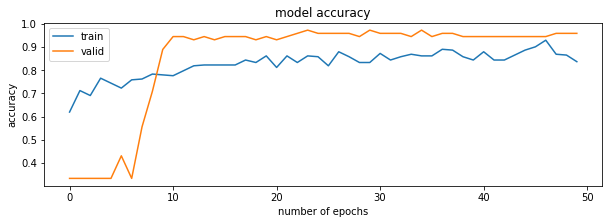

In [202]:
submission_predictions = []
for epoch, skf_splits in zip(range(0,N_FOLDS),skf.split(trainX,trainYSparse)):

    train_idx = skf_splits[0]
    val_idx = skf_splits[1]
    print(len(train_idx),len(val_idx))
    
    # Create Model..........................................
    # Input layer
    img_dims=224
    inputs = Input(shape=(img_dims, img_dims, 3))

    # 1st conv block
    x = Conv2D(filters=64, kernel_size=(3, 3), activation='relu', trainable=False, padding='same')(inputs)
    x = Conv2D(filters=64, kernel_size=(3, 3), activation='relu', trainable=False, padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPool2D(pool_size=(2, 2))(x)

    # 2nd conv block
    x = Conv2D(filters=128, kernel_size=(3, 3), activation='relu', trainable=False, padding='same')(x)
    x = Conv2D(filters=128, kernel_size=(3, 3), activation='relu', trainable=False, padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPool2D(pool_size=(2, 2))(x)

    # 3rd conv block
    x = Conv2D(filters=256, kernel_size=(3, 3), activation='relu', trainable=False, padding='same')(x)
    x = Conv2D(filters=256, kernel_size=(3, 3), activation='relu', trainable=False, padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPool2D(pool_size=(2, 2))(x)

    # 4th conv block
    x = Conv2D(filters=512, kernel_size=(3, 3), activation='relu', trainable=False, padding='same')(x)
    x = Conv2D(filters=512, kernel_size=(3, 3), activation='relu', trainable=False, padding='same')(x)
    x = Conv2D(filters=512, kernel_size=(3, 3), activation='relu', trainable=False, padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPool2D(pool_size=(2, 2))(x)

    # 5th conv block
    x = Conv2D(filters=512, kernel_size=(3, 3), activation='relu', trainable=False, padding='same')(x)
    x = Conv2D(filters=512, kernel_size=(3, 3), activation='relu', trainable=False, padding='same')(x)
    x = Conv2D(filters=512, kernel_size=(3, 3), activation='relu', trainable=False, padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPool2D(pool_size=(2, 2))(x)
#     x = AveragePooling2D(pool_size=(4, 4))(x)

    # LSTM layer
    x = Reshape((49, 512))(x)
    x = ((LSTM(512, activation="relu", return_sequences=True, trainable=False)))(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    
    # FC layer
    x = Flatten(name="flatten")(x)
    x = Dense(units=64, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)

    # Output layer
    output = Dense(units=3, activation='softmax')(x)

    model = Model(inputs=inputs, outputs=output)
#  opt=Adam(lr=0.01)
#    opt = Adam(0.001)
    opt = RMSprop(lr=0.0001, decay=1e-6)
    model.compile(loss='categorical_crossentropy',
                  optimizer=opt, metrics=["accuracy"])
#                   metrics=['acc', tf.keras.metrics.AUC()],experimental_run_tf_function=False)
#     model.summary()
    
    if epoch != 0:
        # Load Model Weights
        model.load_weights('best_cnn_model.h5') 
    
    history = model.fit(
                train_datagen.flow(trainX[train_idx], trainY[train_idx], batch_size=T_BS),
                steps_per_epoch=len(train_idx) // T_BS,
                epochs=EPOCHS,
                validation_data = val_datagen.flow(trainX[val_idx], trainY[val_idx], batch_size=V_BS),
                validation_steps = len(val_idx) // V_BS,
                callbacks=callbacks)
    fig, ax = plt.subplots(1, 2, figsize=(10, 3))
    ax = ax.ravel()
    for i, met in enumerate(['accuracy', 'loss']):
        ax[i].plot(history.history[met])
        ax[i].plot(history.history['val_' + met])
        ax[i].set_title('Model {}'.format(met))
        ax[i].set_xlabel('epochs')
        ax[i].set_ylabel(met)
        ax[i].legend(['train', 'val'])
    
    predY = model.predict(testX, batch_size=V_BS)
    confusion__matrix=confusion_matrix(testY, np.argmax(predY, axis = -1))
    print(classification_report(testY, np.argmax(predY, axis = -1), target_names = ['normal', 'covid', 'pneumonia']))
    print(confusion__matrix)
    
    
    if epoch >= 1:
        preds = model.predict(testX, batch_size=V_BS)
        submission_predictions.append(preds)
    
    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='valid')
    plt.title("model loss")
    plt.ylabel("loss")
    plt.xlabel("number of epochs")
    plt.legend(["train", "valid"], loc="upper left")
    plt.savefig('loss_performance'+'_'+str(epoch)+'.png')
    plt.clf()
    plt.plot(history.history['accuracy'], label='train')
    plt.plot(history.history['val_accuracy'], label='valid')
    plt.title("model accuracy")
    plt.ylabel("accuracy")
    plt.xlabel("number of epochs")
    plt.legend(["train", "valid"], loc="upper left")
    plt.savefig('accuracy_performance'+'_'+str(epoch)+'.png')
    
    del history
    model
    gc.collect()
    

In [203]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

### Plot trining metrics

In [204]:
model.summary()

Model: "model_40"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_41 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 conv2d_480 (Conv2D)         (None, 224, 224, 64)      1792      
                                                                 
 conv2d_481 (Conv2D)         (None, 224, 224, 64)      36928     
                                                                 
 batch_normalization_280 (Ba  (None, 224, 224, 64)     256       
 tchNormalization)                                               
                                                                 
 max_pooling2d_200 (MaxPooli  (None, 112, 112, 64)     0         
 ng2D)                                                           
                                                                 
 conv2d_482 (Conv2D)         (None, 112, 112, 128)     738

### Evaluation

In [205]:
predY = np.average(submission_predictions, axis = 0, weights = [2**i for i in range(len(submission_predictions))])

ZeroDivisionError: Weights sum to zero, can't be normalized

In [206]:
roc_auc_score(testY, predY, multi_class='ovo')

0.9963066034494606

In [207]:
roc_auc_score(testY, predY, multi_class='ovr')

0.9963086009597637

In [208]:
class_to_label_map = {2 : 'pneumonia', 1 : 'covid', 0 : 'normal'}

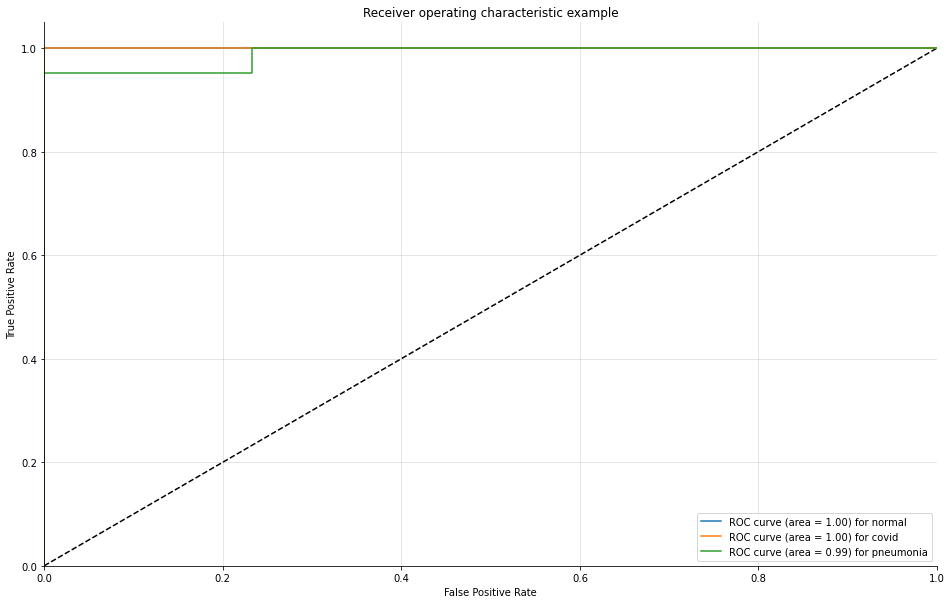

In [209]:
import seaborn as sns
def plot_multiclass_roc(y_test, y_score, n_classes, figsize=(17, 6)):

    # structures
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    # calculate dummies once
    y_test_dummies = pd.get_dummies(y_test, drop_first=False).values
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_dummies[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # roc for each class
    fig, ax = plt.subplots(figsize=figsize)
    ax.plot([0, 1], [0, 1], 'k--')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title('Receiver operating characteristic example')
    for i in range(n_classes):
        ax.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f) for %s' % (roc_auc[i], class_to_label_map[i]))
    ax.legend(loc="best")
    ax.grid(alpha=.4)
    sns.despine()
    plt.show()

plot_multiclass_roc(testY, predY, n_classes=3, figsize=(16, 10))

#### Confusion matrix

In [210]:
cm_mat = confusion_matrix(testY, np.argmax(predY, axis = -1))

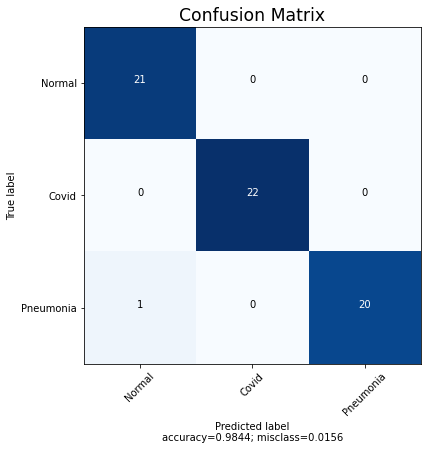

In [211]:
# http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
import numpy as np
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):

    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize = 'xx-large')

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()
    
plot_confusion_matrix(cm_mat, 
                      normalize = False,
                      target_names = ['Normal', 'Covid', 'Pneumonia'],
                      title        = "Confusion Matrix")

In [212]:
print(classification_report(testY, np.argmax(predY, axis = -1), target_names = ['normal', 'covid', 'pneumonia']))

              precision    recall  f1-score   support

      normal       0.95      1.00      0.98        21
       covid       1.00      1.00      1.00        22
   pneumonia       1.00      0.95      0.98        21

    accuracy                           0.98        64
   macro avg       0.98      0.98      0.98        64
weighted avg       0.99      0.98      0.98        64



In [213]:
!rm -rf dataset
!rm -rf logs

'rm' is not recognized as an internal or external command,
operable program or batch file.
'rm' is not recognized as an internal or external command,
operable program or batch file.
